In [2]:
!git clone https://github.com/openaifab/suicide_lstm.git

Cloning into 'suicide_lstm'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 5), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [3]:
%cd suicide_lstm

/content/suicide_lstm


In [4]:
%pwd

'/content/suicide_lstm'

In [29]:
#!pip install tensorflow-gpu==2.1.0
!pip install hanziconv

     |████████████████████████████████| 286kB 2.6MB/s 
  Created wheel for hanziconv: filename=hanziconv-0.3.2-py2.py3-none-any.whl size=23215 sha256=06c75cf5161d69f48ad4ff0ee700504a3e7568930da7bc2e6a4cc3ab674f84d2
  Stored in directory: /root/.cache/pip/wheels/03/d8/3c/c39898fa9c9ce6e34b0ab4c6604892462d440c743715c94054
Successfully built hanziconv


In [0]:
from hanziconv import HanziConv

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [0]:
import pandas as pd
import jieba.posseg as pseg
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import os

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [0]:
def jieba_tokenizer(text):
  pattern = re.compile(r'[^\u4e00-\u9fa5]')
  chinese = re.sub(pattern, '', text)
  chinese = HanziConv.toSimplified(chinese)
  words = pseg.cut(chinese)
  '''
  return ' '.join([
        word for word, flag in words if flag != 'x' and flag!='y'and word!='丶'] )
  '''
  
  return ' '.join([
        word for word, flag in words])

pos_train_filename = 'source/normal.txt'
neg_train_filename = 'source/die.txt'

col_name=['content']

In [9]:
pos_train_df =  pd.read_table(pos_train_filename,names=col_name)
neg_train_df =  pd.read_table(neg_train_filename,names=col_name)

#make positive data less
pos_train_df = pos_train_df[:600]
######

print(pos_train_df)
print(neg_train_df)

                                               content
0    预计标普期货再下跌5个指数点，市场情绪将有回归到平和状态，现在的标普下跌是将极端乐观的市场情...
1    #2017四川公安舟船演练#乘风破浪，奋勇争先，为了肩头的使命与担当，为了警察的职责与荣耀。...
2    会有签售呀！本周日下午1:30，在中关村言几又书店！！！！你就可以现场看到我有多胖了！！！ ...
3       【活动】“博物馆里的非遗美术课”5-6月份活动回顾。http://t.cn/R5NeXW4 
4    【全国高校外卖订单量30强出炉 你平时都点啥[围观]】近日，某在线外卖订餐平台对全国高校外卖...
..                                                 ...
595  【74岁老太替儿还债，挑60斤菜进城卖[悲伤]】山东济南74岁老人赵殿香，每天四五点起床，挑...
596  #北京事儿#【[祈祷]】@小镚儿奴才 ：早起坐车上班在东四环辅路，看见一个流浪汉衣衫褴褛，把...
597                        北京街拍更新，小小复古斑点红裙，freestyle！ 
598  #每日震知道# #地震科普# 震今召、震名人，希望大家都来关注，转起来！#北京政在说# @中...
599                            #北京夜聊#说说你是因为什么而留在北京的…… 

[600 rows x 1 columns]
                                               content
0                                     我丶不配丶结束饭。我好累啊。饭。
1             钓鱼的小橘猫很多时候，我能感觉到自己没有未来，就像一切都会在下一秒结束，包括生命
2                                 大乔617走饭我好想死，但。。。唉╯﹏╰
3                                   我自己都放弃了自己 更不要说是别人了
4    我告诉自己 还能撑住 但我也不知道能撑到什么时候 我准备搬家了 我要换个

In [10]:
pos_train_df['content_tokenized'] = pos_train_df.loc[:, 'content'].apply(jieba_tokenizer)
neg_train_df['content_tokenized'] = neg_train_df.loc[:, 'content'].apply(jieba_tokenizer)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.926 seconds.
Prefix dict has been built successfully.


In [11]:
print(pos_train_df['content_tokenized'])
print(neg_train_df['content_tokenized'])
print("\n total x_train:", len(pos_train_df)+len(neg_train_df))

0      预计 标普 期货 再 下跌 个 指数 点 市场 情绪 将 有 回归 到 平和 状态 现在 的...
1      四川 公安 舟船 演练 乘风破浪 奋勇争先 为了 肩头 的 使命 与 担当 为了 警察 的 ...
2      会 有 签售 呀 本周 日 下午 在 中关村 言 几 又 书店 你 就 可以 现场 看到 我...
3                            活动 博物馆 里 的 非 遗 美术课 月份 活动 回顾
4      全国 高校 外卖 订单 量 强 出炉 你 平时 都 点 啥 围观 近日 某 在线 外卖 订餐...
                             ...                        
595    岁 老太 替 儿 还债 挑 斤 菜 进城 卖 悲伤 山东 济南 岁 老人 赵殿香 每天 四五...
596    北京 事儿 祈祷 小镚儿 奴才 早起 坐车 上班 在 东四环 辅路 看见 一个 流浪汉 衣衫...
597                                北京 街 拍 更新 小小 复古 斑点 红裙
598    每日 震 知道 地震 科普 震今 召震 名人 希望 大家 都 来 关注 转 起来 北京 政在...
599                        北京 夜 聊 说 说 你 是因为 什么 而 留在 北京 的
Name: content_tokenized, Length: 600, dtype: object
0                                 我 丶 不配 丶 结束 饭 我 好累 啊 饭
1      钓鱼 的 小橘 猫 很多 时候 我 能 感觉 到 自己 没有 未来 就 像 一切 都 会 在...
2                                      大乔 走饭 我 好 想 死 但 唉
3                           我 自己 都 放弃 了 自己 更 不要 说 是 别人 了
4      我 告诉 自己 还 能 撑住 但 我 也 不 知道 能撑 到 什么 时候 我 准备 搬家 了...
                             ...    

In [12]:
pos_train_df['label'] = 0
neg_train_df['label'] = 1

#print(pos_train_df['label'])
#print(neg_train_df['label'])

y_train = pd.concat([pos_train_df['label'],neg_train_df['label']])
print(y_train)
print("")
print("total y_train:", len(y_train))
print("")
y_train = np.array(y_train)
print(y_train)

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: label, Length: 900, dtype: int64

total y_train: 900

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

In [13]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

corpus_x1 = pos_train_df.content_tokenized
corpus_x2 = neg_train_df.content_tokenized
corpus = pd.concat([corpus_x1, corpus_x2],ignore_index=True)

print(corpus.shape)
print(corpus)

(900,)
0      预计 标普 期货 再 下跌 个 指数 点 市场 情绪 将 有 回归 到 平和 状态 现在 的...
1      四川 公安 舟船 演练 乘风破浪 奋勇争先 为了 肩头 的 使命 与 担当 为了 警察 的 ...
2      会 有 签售 呀 本周 日 下午 在 中关村 言 几 又 书店 你 就 可以 现场 看到 我...
3                            活动 博物馆 里 的 非 遗 美术课 月份 活动 回顾
4      全国 高校 外卖 订单 量 强 出炉 你 平时 都 点 啥 围观 近日 某 在线 外卖 订餐...
                             ...                        
895    您 说 咸鱼 十九 贵 吗 好 累 哦 家里 破事 一堆 暗恋 刚 开始 就 结束 了 我 ...
896    我 好像 没有 想活 的 欲望 了 每天 都 会 崩溃 无缘 的 发脾气 动不动 就 哭 我...
897    第 无数次 想要 离开 复发 我 真的 觉得 我 好 不 起来 了 这辈子 都 好 不 起来...
898    玖 少年 团 肖战 的 老婆 我 感觉 自己 已经 精神分裂 了 我 真的 很 不想 活着 ...
899                        不要 再 劝 我 了 我 已经 决定 好 了 不会 变 了
Name: content_tokenized, Length: 900, dtype: object


In [0]:
len(corpus[0])

377

In [14]:
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print("total volcabulary:", len(word_index))
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("key 1 is:", reverse_word_index[1])
print("key 2 is:", reverse_word_index[2])

joblib.dump(tokenizer,'tk.pkl')

x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

max_seq_len = max([len(seq) for seq in x1_train])
print("max lenght of the sentence is:", max_seq_len)
#os._exit() 

total volcabulary: 10864
key 1 is: <OOV>
key 2 is: 的
max lenght of the sentence is: 3984


In [15]:
MAX_SEQUENCE_LENGTH = 5000 #max_seq_len
x1_train_padded = pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH, truncating='post') #normal
x2_train_padded = pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH, truncating='post') #die

x_train_padded=np.vstack((x1_train_padded,x2_train_padded))
print(x_train_padded)

[[   0    0    0 ...  773 4548 4549]
 [   0    0    0 ...    2   67   17]
 [   0    0    0 ...   10 1877 1878]
 ...
 [   0    0    0 ...   29  219   36]
 [   0    0    0 ...   32    1   18]
 [   0    0    0 ...  237  331    4]]


In [0]:
x1_train[0]

In [0]:

len(x_train_padded[0])

5000

In [18]:
VALIDATION_RATIO = 0.2
RANDOM_STATE = 9527

x_train, x_val, y_train, y_val = train_test_split(x_train_padded, y_train, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

print("Training Set")
print("-" * 10)
print(f"x_train: {x_train.shape}")

print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x_val:   {x_val.shape}")

print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x_train: (720, 5000)
y_train : (720,)
----------
x_val:   (180, 5000)
y_val :   (180,)
----------
Test Set


In [19]:
# 一個詞向量的維度
EMBEDDING_DIM = 128

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # try if it gets better accuracy
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # try if it gets better accuracy
    #tf.keras.layers.Dense(16, activation='relu'),  #16, 24
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,321,281
Trainable params: 1,321,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [20]:
# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 32

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 10

# 實際訓練模型
history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val, y_val), shuffle=True
                    #,callbacks=[callbacks]
)

model.save('lstm.h5')

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/10


In [21]:
MAX_SEQUENCE_LENGTH = 5000

model=keras.models.load_model('lstm.h5')
print(model.summary())

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
______________________

In [22]:
import os
os.chdir("/")

from google.colab import drive
try:
    drive.mount('content/gdrive', force_remount=True)
except:
    print('你的 drive 掛載不成功')
    
os.chdir("/content/gdrive/My Drive/colab/suicide_model/dataset")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content/gdrive


In [23]:
pwd

'/content/gdrive/My Drive/colab/suicide_model/dataset'

In [0]:
data=pd.read_csv("1199-1149-1000.csv")

In [0]:
data['content_tokenized']=data['content'].apply(jieba_tokenizer)

In [42]:
data['content_tokenized']

0      虽然 准备 好 要 找 工作 了 一 波波 的 面试 袭 来 从小到大 我 最 恐惧 的 就...
1      基本上 任何 的 情绪 都 可以 好好 分享 不管 忧郁 快乐 都 能 尽情 抒发 绝对 能...
2      作者 看 板 标题 求助 有人 参加 过 医院 举办 的 职能 训练 吗 时间 有人 参加 ...
3      不 只 一次 梦见 自己 过 着 不 一样 的 人生 同样 是 我 同样 的 亲人 却 在 ...
4      自从 上份 打工 辞掉 后 基本上 就是 继续 的 工作 这 波 疫情 难免会 有 影响 待...
                             ...                        
994    想 问 大家 有人 是 吃 的 吗 吃 了 之后 有 什么 副作用 之类 的 我 目前 已经...
995    缺乏 跟 这个 现实 世界 的 连结 活 在 自己 幻想 出来 的 美好世界 很 困惑 到底...
996    如果 真的 每件事 的 发生 都 有 他 的 意义 存在 那么 有 忧郁症 又 是 将 带来...
997    最近 状况 突然 低落 了 再次 疲倦 无时无刻 想 睡 提不起 劲 没有 兴趣 暴躁 易怒...
998    反正 恶人 一直 觉得 自己 没错 我 也 不是 很 想活 了 你们 的 名字 我 都 会 ...
Name: content_tokenized, Length: 999, dtype: object

In [43]:
data_test = tokenizer.texts_to_sequences(data.content_tokenized)
data_test = keras.preprocessing.sequence.pad_sequences(data_test, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')
predictions = model.predict(data_test)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [0]:
predictions 

In [0]:
data['自殺評估程度']=predictions*100 

In [47]:
data

,content,label,content_tokenized,自殺評估程度
0,雖然準備好要找工作了一波波的面試襲來從小到大我最恐懼的就是面試跟結婚生小孩每到陌生的地方就開...,NaN,虽然 准备 好 要 找 工作 了 一 波波 的 面试 袭 来 从小到大 我 最 恐惧 的 就...,97.032814
1,基本上，任何的情緒都可以好好分享，不管憂鬱、快樂都能盡情抒發。絕對能讓每一個人好好的抒發情緒...,NaN,基本上 任何 的 情绪 都 可以 好好 分享 不管 忧郁 快乐 都 能 尽情 抒发 绝对 能...,40.798180
2,作者: mango2014 (coco) 看板: Psychiatry標題: [求助] 有人...,NaN,作者 看 板 标题 求助 有人 参加 过 医院 举办 的 职能 训练 吗 时间 有人 参加 ...,39.288246
3,不只一次夢見自己過著不一樣的人生。同樣是我，同樣的親人，卻在不一樣的時空裡過著不一樣的生活。...,NaN,不 只 一次 梦见 自己 过 着 不 一样 的 人生 同样 是 我 同样 的 亲人 却 在 ...,98.397758
4,自從上份打工辭掉後，基本上就是繼續SOHO的工作，這波疫情難免會有影響，待在家的時間又更長，...,NaN,自从 上份 打工 辞掉 后 基本上 就是 继续 的 工作 这 波 疫情 难免会 有 影响 待...,96.697906
...,...,...,...,...
994,想問大家有人是吃fluxen的嗎吃了之後有什麼副作用之類的我目前已經吃第9天了 感覺變得比較...,NaN,想 问 大家 有人 是 吃 的 吗 吃 了 之后 有 什么 副作用 之类 的 我 目前 已经...,96.793671
995,缺乏跟這個現實世界的連結，活在自己幻想出來的美好世界很困惑到底現在的這個我是現實還是我幻想的...,NaN,缺乏 跟 这个 现实 世界 的 连结 活 在 自己 幻想 出来 的 美好世界 很 困惑 到底...,96.427361
996,如果真的每件事的發生都有他的意義存在那麼有憂鬱症又是將帶來什麼讓自己的步調變慢了講話變得有氣...,NaN,如果 真的 每件事 的 发生 都 有 他 的 意义 存在 那么 有 忧郁症 又 是 将 带来...,90.599403
997,最近狀況突然低落了再次疲倦 無時無刻想睡 提不起勁 沒有興趣 暴躁易怒飯桌上沈默麻木，媽媽問...,NaN,最近 状况 突然 低落 了 再次 疲倦 无时无刻 想 睡 提不起 劲 没有 兴趣 暴躁 易怒...,98.377731


In [0]:
data.to_csv('1199-1149-1000_p.csv',columns=['content','自殺評估程度'])

In [0]:
pos_test_filename = 'source/normal_test.txt'
neg_test_filename = 'source/die_test.txt'

col_name=['content']

pos_test_df =  pd.read_table(pos_test_filename,names=col_name)
neg_test_df =  pd.read_table(neg_test_filename,names=col_name)

pos_test_df['content_tokenized'] = pos_test_df.loc[:, 'content'].apply(jieba_tokenizer)
neg_test_df['content_tokenized'] = neg_test_df.loc[:, 'content'].apply(jieba_tokenizer)
pos_test_df['label'] = 0
neg_test_df['label'] = 1
print(len(pos_test_df['content_tokenized']))
print(len(neg_test_df['content_tokenized']))

test_df=pd.concat([pos_test_df,neg_test_df],ignore_index=True)
print(test_df)
max_seq_len = max([len(seq) for seq in test_df['content_tokenized']])
print(max_seq_len)
#MAX_NUM_WORDS = 10000

50
50
                                              content  ... label
0   存 酒鬼们！！快来！！马上就国庆长假了！与其到外面拥挤的出游，不如在家喝大酒啊！！和男票和两...  ...     0
1   《很纯很暧昧》：怪我太傻！信了你的假名！为什么我的双眼常常通红，因为辣的呗......[do...  ...     0
2   美呆啦！提神养眼的倪妮和X9s CP[太开心] 【还有2天】喵总说：TA是一道柔光，把美好的...  ...     0
3   应该是我的了[doge] 告诉你，你与国庆假期只差一台单反相机！佳能单反一台，喜欢就拿走，假...  ...     0
4   怎么会有颜值担当这样的职位，我这样的小仙女都没这么说[笑cry] 猜猜我们园区今天会有啥黑科...  ...     0
..                                                ...  ...   ...
95                                 蝉咽w我什么都不想要 我只想要安乐死  ...     1
96                       如果我消失了呢两次误机，老天是不想让我死还是想继续折磨我  ...     1
97                  无味甜饼我想死了 可是找不到合适的方式 害怕痛苦 可是活着更加痛苦  ...     1
98                                      蝉咽w不然一切早就该结束了  ...     1
99                                          为什么要这么折磨我  ...     1

[100 rows x 3 columns]
346


In [0]:
tokenizer = joblib.load('tk.pkl')

x1_test = tokenizer.texts_to_sequences(pos_test_df.content_tokenized)
x2_test = tokenizer.texts_to_sequences(neg_test_df.content_tokenized)

x1_test = keras.preprocessing.sequence.pad_sequences(x1_test, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')
x2_test = keras.preprocessing.sequence.pad_sequences(x2_test, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')

x_test=np.vstack((x1_test,x2_test))
print(x_test)

#generate true label data here
y_test = pd.concat([pos_test_df['label'],neg_test_df['label']])
y_test = np.array(y_test)
print(y_test)
print("")
print("total y_train:", len(y_test))
print("")

[[   0    0    0 ... 2329  184    1]
 [   0    0    0 ...   33   25   17]
 [   0    0    0 ...   33   25   17]
 ...
 [   0    0    0 ...  139 1142  172]
 [   0    0    0 ...  195   79    4]
 [   0    0    0 ...  269 1082    3]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

total y_train: 100



In [0]:
x_test=np.repeat(x_test, 10, axis = 0)
len(x_test)

1000

In [0]:
y_test=np.repeat(y_test, 10, axis = 0)

In [0]:
predictions = model.predict(x_test)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_10324 in device /job:localhost/replica:0/task:0/de

In [0]:
test_df['label']=np.apply_along_axis(lambda x: 1 if x > 0.5 else 0, 1, predictions)
print(np.array(test_df['label']))
for index, row in test_df.iterrows():
    print('index:{},content:{},label:{}'.format(index,row['content'],row['label']))

[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
index:0,content:存 酒鬼们！！快来！！马上就国庆长假了！与其到外面拥挤的出游，不如在家喝大酒啊！！和男票和两三好友一起喝着小酒儿，聊着八卦，看着小片儿～～超爽的！！如果你有失眠晚睡的情况，晚上喝着这些小酒能更好帮助我们入睡！！喝酒要微醺才是真理！！宠粉狂魔知道酒鬼们有很多哈哈哈，为你们拿到超多折 ,label:0
index:1,content:《很纯很暧昧》：怪我太傻！信了你的假名！为什么我的双眼常常通红，因为辣的呗......[doge] 精分少女蛋蛋酱的秒拍视频 ,label:0
index:2,content:美呆啦！提神养眼的倪妮和X9s CP[太开心] 【还有2天】喵总说：TA是一道柔光，把美好的世界照亮。7月6日，vivo X9s|X9s Plus新品上市品鉴会，让@倪妮V 和X9s一起照亮你的世界。#vivo2000万双摄X9s# 秒拍视频 ,label:0
index:3,content:应该是我的了[doge] 告诉你，你与国庆假期只差一台单反相机！佳能单反一台，喜欢就拿走，假期那么长，我想去看看[害羞] ,label:0
index:4,content:怎么会有颜值担当这样的职位，我这样的小仙女都没这么说[笑cry] 猜猜我们园区今天会有啥黑科技[挤眼] ,label:1
index:5,content:行走获得新高度@三联中读 @三联生活周刊 南京·玄武区 ,label:0
index:6,content:哇！微博名称和实际名字不符，真可怜！ 发表了博文 《太平天国的制度困境》 - 【时间】：6月15日（周日14：30-17：00） 【主题】：太平天国的制度困境 【地点】：彼岸书店（北航店） ，（北京市海淀区北四环中路238号柏彦大厦306 太平天国的制度困境 ,label:0
index:7,content:全文  【广州独

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
plot_graphs(history, 'acc')

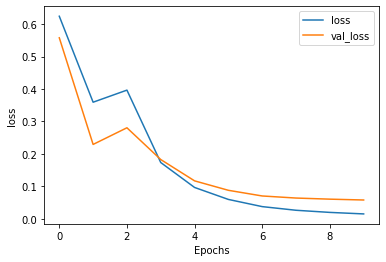

In [0]:
plot_graphs(history, 'loss')

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 128)


##Test Model

In [0]:
tests = ['钓鱼的小橘猫很多时候，我能感觉到自己没有未来，就像一切都会在下一秒结束，包括生命',
         '我会在二十八岁结束了这潦草的一生对吧',
         '最爱灼灼华年我真的好想死啊',
         '我好烦。今天怎么还没死。',
         '#2017四川公安舟船演练#乘风破浪，奋勇争先，为了肩头的使命与担当，为了警察的职责与荣耀。[加油] 四川公安的微博视频 ']
sentences = []
for s in tests:
  sentences.append(jieba_tokenizer(s))
sequence = tokenizer.texts_to_sequences(sentences)
print(sequence)

r = model.predict(pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, truncating='post'))
print(r)
for u, v in list(zip(sentences, r)):
    rating = 'Good' if v[0] < 0.5 else 'Bad'
    print(f'{u} → {rating}')

[[1, 2, 1, 1437, 463, 129, 3, 50, 213, 23, 27, 58, 257, 10, 145, 227, 11, 22, 6, 112, 1146, 82, 1101, 376], [805, 6, 1, 82, 4, 26, 1, 2, 546, 53], [54, 57, 1, 1449, 47, 3, 67, 19, 13, 14], [3, 1, 63, 110, 46, 2813], [75, 356, 473, 4773, 4774, 4775, 4776, 302, 4777, 2, 1466, 39, 1467, 302, 512, 2, 4778, 39, 624, 277, 356, 473, 2, 76, 17]]
[[0.9852321 ]
 [0.98001593]
 [0.98846567]
 [0.95916885]
 [0.00916184]]
钓鱼 的 小橘 猫 很多 时候 我 能 感觉 到 自己 没有 未来 就 像 一切 都 会 在 下 一秒 结束 包括 生命 → Bad
我会 在 二十八岁 结束 了 这 潦草 的 一生 对 → Bad
最 爱 灼灼 华 年 我 真的 好 想 死 → Bad
我 好烦 今天 怎么 还 没死 → Bad
2017 四川 公安 舟船 演练 乘风破浪 奋勇争先 为了 肩头 的 使命 与 担当 为了 警察 的 职责 与 荣耀 加油 四川 公安 的 微博 视频 → Good


##Visualize embeddings

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
#visit website: projector.tensorflow.org